In [8]:
%config IPCompleter.greedy=True 
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import code_two_states.interface_graph as inter
import code_two_states.generation_sequences as ge 
import code_two_states.inference_partners as inf
import code_two_states.loop_function as lp
from code_two_states.utility_plot import *
import pickle
import seaborn as sns

########## ASPECT #################
width = "article"
width_pt = 430.00462

cmaps_sns = sns.color_palette("colorblind", 10)
l_AF = [0, 3, 2, 8, 1, 4, 5, 6, 7, 9]
cmaps = []
for i in l_AF:
    cmaps.append(cmaps_sns[i])
sns.set_theme(context='notebook', style='ticks', palette=cmaps, color_codes=True, rc=None)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "arial",
    # Use 10pt font in plots, to maT_ch 10pt font in document
    "font.size": 9.8,
    "axes.titlesize" : 9.8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth" : 1.3,
    'axes.linewidth' : 1,
}

plt.rcParams.update(tex_fonts)
########## ASPECT #################

rng = np.random.default_rng()

### Dont touch this parameter #####
Size_Block = [100,100]
#p_in = 0.025
#p_out = 0.005
p_in = 0.02
p_out = 0.005

number_node_in_contact = 10
p_in_interface = 0.02
p_out_interface = 0.25

#################################
generate_graph = False ## Generate new graph with above parameter

###### INFERENCE #############
s_train = 400
pseudo_count = 0.5
n_pair_species = 4
theta = 0
n_avg_permut_train_test = 20
##############################

## Generation sequences ####
n_avg_sampling = 20
n_mutations_branch = 15
prob_mutation_site = n_mutations_branch/200
n_generations = 10 # 2^10 = 1024 chain of spin
n_seq = int(2**n_generations)


l_letter = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
def annotate(i, ax=None):
    if ax is None:
        plt.annotate(l_letter[i], xy=(-0.1, 1.1), xycoords='axes fraction')
    else:
        ax.annotate(l_letter[i], xy=(-0.1, 1.1), xycoords='axes fraction')
        
def annotate_all(ax):
    try:
        shape = ax.shape
    except:
        #no shape so no panels
        return None
    
    if len(ax.shape)==1:
        n = ax.shape[0]
        for i in range(n):
            annotate(i, ax=ax[i])
    elif len(ax.shape)==2:
        n,k = ax.shape
        for i in range(n):
            for j in range(k):
                annotate(i*n + j, ax=ax[i,j])

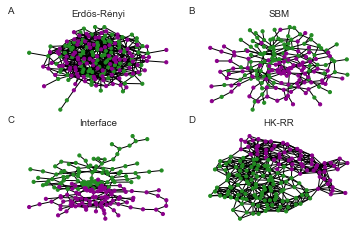

In [9]:
if generate_graph:
    Graph_SBM = nx.random_partition_graph(Size_Block, p_in, p_out)
    nx.write_gexf(Graph_SBM,"graphes/Graph_SBM")

    #p_in_2 = 0.025
    #p_out_2 = 0.02
    #Graph_SBM_2 = nx.random_partition_graph(Size_Block,p_in_2,p_out_2)
    
    Graph_Interface = inter.Interface_Graph(Size_Block, p_in_interface, p_out_interface, number_node_in_contact, seed=None)
    nx.write_gexf(Graph_Interface,"graphes/Graph_Interface")

m_adj = np.load("graphes/matcontact_andonis.npy")
Graph_erdos = nx.convert_matrix.from_numpy_matrix(m_adj)
Graph_erdos.name = "Erdős-Rényi"

Graph_SBM = nx.read_gexf("graphes/Graph_SBM",node_type = int)
Graph_SBM.name = "SBM"

Graph_Interface = nx.read_gexf("graphes/Graph_Interface",node_type = int)

Graph_HK_RR = nx.read_gexf("graphes/Extract_contact_pdb_HK-RR/Graph_HK_and_RR_Threshold_4",node_type = int)
Graph_HK_RR.name = "HK-RR"

### Liste Graph
L_Graph = [Graph_erdos, Graph_SBM, Graph_Interface, Graph_HK_RR]
###
Number_Graph = len(L_Graph)

figsize=set_size(width,subplots=(2,2))
plt.figure(figsize=figsize)  
for i in range(len(L_Graph)):
    node_color = []
    for node in range(len(L_Graph[i])):
        if L_Graph[i].nodes("subset")[node] == None:
            if node//Size_Block[0] == 0:
                L_Graph[i].nodes[node]["subset"] = 0
            else:
                L_Graph[i].nodes[node]["subset"] = 1
        if L_Graph[i].nodes[node]["subset"] == 0:
            node_color.append("forestgreen")
        else:
            node_color.append("darkmagenta")
    plt.subplot(2,Number_Graph//2 + Number_Graph%2 ,i+1)
    nx.draw_kamada_kawai(L_Graph[i],with_labels=False , node_size=10, node_color=node_color)
    annotate(i)
    plt.title(str(L_Graph[i]))

plt.savefig("figures_different_graphs/Graph_used.eps",bbox_inches = "tight")
plt.show()


## Equilibrium for each graph

In [10]:
import time

ll_t = [[3,4.2,5], [1.5,2.1,3], [1.8,2.3,3], [5,7.1,9]]
L_max_flip = [10000]*(len(L_Graph)-1) + [20000]
n_seq = 1000

num_t = len(ll_t[0])
l_graph_temp = []
l_graph_flip = []
M_msa_hist = np.zeros((len(L_Graph),num_t,n_seq))
for i in range(len(L_Graph)):
    Graph = L_Graph[i]
    MSA = ge.Sampling_msa_two_states(Graph)
    max_flip = L_max_flip[i]
    delta_flip = int(max_flip/100)
    l_t_plot = []
    tot_time = 0
    l_t = ll_t[i]
    for i_t,t in enumerate(l_t):
        MSA.T = t
        msa = np.random.randint(2,size=(n_seq, Graph.number_of_nodes()), dtype = np.int8)*2-1
        l_plot = [np.mean(np.abs(np.mean(msa,axis=1)))]
        l_flip = [0]
        c = 0
        while c<max_flip:
            for j in range(msa.shape[0]):
                MSA.mcmc(delta_flip,msa[j])
            c+=delta_flip
            l_plot.append(np.mean(np.abs(np.mean(msa,axis=1))))
            l_flip.append(c)
        M_msa_hist[i,i_t] = np.mean(msa,axis=1)
        l_t_plot.append(l_plot)
    l_graph_flip.append(l_flip)
    l_graph_temp.append(l_t_plot)

Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000
Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000
Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000
Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000


<Figure size 428.398x211.812 with 0 Axes>

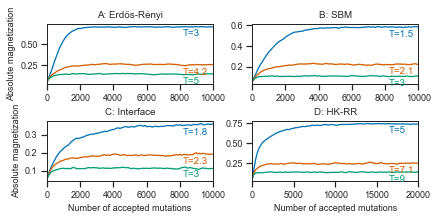

In [11]:
figsize=set_size(width,subplots=(2,2),scale_height=0.8)
plt.figure(figsize=figsize)
fig, ax =  plt.subplots(figsize=figsize, ncols=2, nrows=2)
for i_graph,graph in enumerate(L_Graph):
    l_t = ll_t[i_graph]
    for i,t in enumerate(l_t):
        l_t_plot =  l_graph_temp[i_graph]
        ax[i_graph//2,i_graph%2].plot(l_graph_flip[i_graph],l_t_plot[i],label="T=%s"%np.round(t,1))
        ax[i_graph//2,i_graph%2].margins(x=0)
        
        delta_annot = -19
        delta_pos = -0.17*(np.max(l_t_plot)-np.min(l_t_plot))
        ax[i_graph//2,i_graph%2].annotate("T=%s"%np.round(t,1), 
            xy=(l_graph_flip[i_graph][delta_annot], l_t_plot[i][delta_annot]), 
            xytext=(l_graph_flip[i_graph][delta_annot], l_t_plot[i][delta_annot] + delta_pos),
            color = cmaps[i])
        
        if i_graph==2:
            ax[i_graph//2,i_graph%2].set_xlabel("Number of accepted mutations")
            ax[i_graph//2,i_graph%2].set_ylabel("Absolute magnetization")
        if i_graph==0:
            ax[i_graph//2,i_graph%2].set_ylabel("Absolute magnetization")
        if i_graph==3:
            ax[i_graph//2,i_graph%2].set_xlabel("Number of accepted mutations")
    ax[i_graph//2,i_graph%2].set_title("%s: %s"%(l_letter[i_graph],str(L_Graph[i_graph])))

fig.tight_layout(pad=0.5)
fig.savefig("figures_different_graphs/S2_magnetisation_graph.eps")

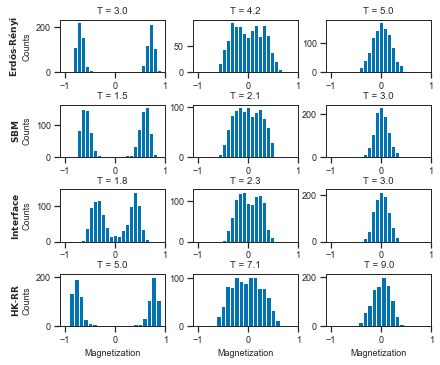

In [12]:
figsize=set_size(width,subplots=(len(L_Graph),len(l_t)),fraction=1)
plt.figure(figsize=figsize)
for i in range(len(L_Graph)):
    Graph = L_Graph[i]
    l_t = ll_t[i]
    for i_t,t in enumerate(l_t):
        plt.subplot(len(L_Graph),len(l_t),(i_t+1) + (i)*len(l_t))
        if i+1==len(L_Graph):
            plt.xlabel("Magnetization")
        if i_t == 0:
            if "-" in str(Graph):
                name_graph = "$\\bf{%s}$"%(str(Graph)[:str(Graph).index("-")]) + "-$\\bf{%s}$"%(str(Graph)[str(Graph).index("-")+1:])
            else:
                name_graph = "$\\bf{%s}$"%(Graph)
            plt.ylabel("%s \nCounts"%(name_graph))
        plt.title("T = %s"%(np.round(t*100)/100))
        bins = np.arange(-1,1,16/Graph.number_of_nodes())
        plt.hist(M_msa_hist[i,i_t],bins=bins,range=(-1,1))
plt.tight_layout(pad=0.1)
plt.savefig("figures_different_graphs/S3_histo_magnetisation.eps", bbox_inches="tight")

# Global parameter

In [13]:
l_tc = [3.8 , 2.7 , 2.4 , 7] ## List of the critical temperature
## Temperature ####
LL_T = [np.linspace(0.5*tc,2.5*tc, num = 20) for tc in l_tc]

# Generation of Sequence

In [14]:
l_graph_temp_no_phylo, l_graph_temp_phylo_equi, l_graph_msa_pure_phylo = [], [], []

for ind_Graph,Graph in enumerate(L_Graph):
    print("Graph : " + str(ind_Graph) )
    sampling = ge.Sampling_msa_two_states(Graph, flip_equi=L_max_flip[ind_Graph]) 

    l_temp = LL_T[ind_Graph]
    n_mutations_branch_graph = int(prob_mutation_site*L_Graph[ind_Graph].number_of_nodes())
    print("%s : %s mutations per generation"%(str(ind_Graph),n_mutations_branch_graph))

    l_graph_temp_no_phylo.append(lp.loop_sampling_temperature(n_avg_sampling, l_temp, sampling, sampling.msa_no_phylo, n_seq))
    l_graph_temp_phylo_equi.append(lp.loop_sampling_temperature(n_avg_sampling, l_temp, sampling, sampling.msa_binary_tree,
                                                             n_generations, n_mutations_branch_graph, 1))

    l_graph_msa_pure_phylo.append(lp.loop_on_function(n_avg_sampling, sampling.msa_binary_tree_pure_phylo,
                                                      n_generations, n_mutations_branch_graph, 0))

Graph : 0
Standard Temperature is 1.0
Number of flip to reach equilibrium is 10000
0 : 15 mutations per generation
Graph : 1
Standard Temperature is 1.0
Number of flip to reach equilibrium is 10000
1 : 15 mutations per generation
Graph : 2
Standard Temperature is 1.0
Number of flip to reach equilibrium is 10000
2 : 15 mutations per generation
Graph : 3
Standard Temperature is 1.0
Number of flip to reach equilibrium is 20000
3 : 13 mutations per generation


## Impact of the temperature on several graph

In [15]:
l_middle_index = [np.argwhere(np.diff([G.nodes[node]["subset"] for node in range(G.number_of_nodes())])==True)[0,0]+1 for G in L_Graph]

kwargs = {"s_train" : s_train,
         "reg": pseudo_count,
          "n_pair" : n_pair_species,
          "theta" : theta,
          "fast" : True,
          "l_middle_index" : l_middle_index,
            "n_mean" : n_avg_permut_train_test,
         }

print(kwargs)
l_no_phylo_temp = lp.loop_inf_partners_diff_graph(inf.Inference_Partner,l_graph_temp_no_phylo,**kwargs)
l_binary_tree_equi_temp = lp.loop_inf_partners_diff_graph(inf.Inference_Partner,l_graph_temp_phylo_equi,**kwargs)

tree_rand_phylo = []
for l_msa_pure_phylo in l_graph_msa_pure_phylo:
    tree_rand_phylo.append(inf.Inference_Partner(l_msa_pure_phylo, s_train, pseudo_count, n_pair_species, theta=theta, fast=True, middle_index=None))

{'s_train': 400, 'reg': 0.5, 'n_pair': 4, 'theta': 0, 'fast': True, 'l_middle_index': [100, 100, 100, 64], 'n_mean': 20}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


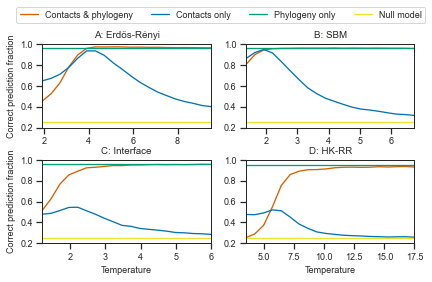

In [16]:
import matplotlib.lines as mlines
label_0 = "Contacts only"
label_2 = "Contacts & phylogeny"
label_3 = "Phylogeny only"
label_4 = "Null model"
ylabel = "Correct prediction fraction"

figsize=set_size(width,subplots=(2,2),scale_height=1)
fig, ax =  plt.subplots(figsize=figsize, ncols=2, nrows=2)
for i in range(len(LL_T)):
    ax[i//2,i%2].plot(LL_T[i],l_binary_tree_equi_temp[i], label=label_2, color=cmaps[1])
    ax[i//2,i%2].plot(LL_T[i],l_no_phylo_temp[i], label=label_0, color=cmaps[0])
    ax[i//2,i%2].plot(LL_T[i],[tree_rand_phylo[i] for t in LL_T[i]], label=label_3, color=cmaps[2])
    ax[i//2,i%2].plot(LL_T[i],[1/n_pair_species for t in LL_T[i]] , label=label_4, color=cmaps[3])
    ax[i//2,i%2].set_title(l_letter[i] + ": " + str(L_Graph[i]))
    ax[i//2,i%2].set_ylim(0.2,1)
    ax[i//2,i%2].margins(x=0)

ax[1,0].set_xlabel("Temperature")
ax[1,1].set_xlabel("Temperature")
ax[0,0].set_ylabel("Correct prediction fraction")
ax[1,0].set_ylabel("Correct prediction fraction")
#ax.semilogx()
#ax[0,0].grid(which='both')
#ax[1,0].grid(which='both')
#ax[0,1].grid(which='both')
#ax[1,1].grid(which='both')

fig.tight_layout(h_pad=0.1)

ax[0,0].legend(bbox_to_anchor=(2.3,1.5),loc='best', ncol=4)


fig.savefig("figures_different_graphs/S6_Partners_temperature_different_graph.eps",bbox_inches = "tight")
plt.show()